In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns 
from scipy.stats import pearsonr, ttest_rel
from scipy import stats
import pickle 

import warnings 
warnings.filterwarnings('ignore')

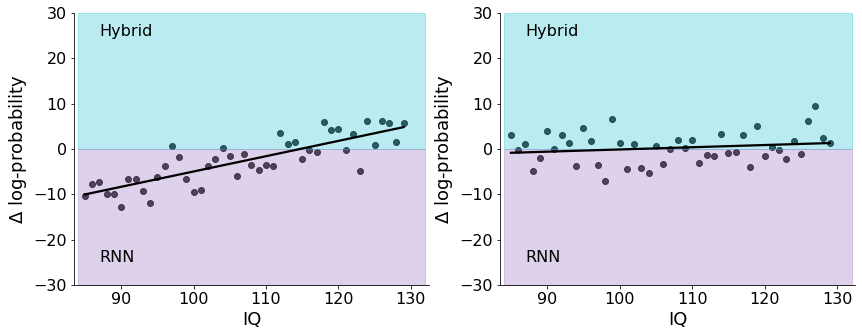

In [2]:
# plot fig_5
fig, axes = plt.subplots(1,2,figsize=(14, 5))
pla = [sns.color_palette("tab10")[9],sns.color_palette("tab10" )[4]]

x = np.arange(85,130)
y = 0.4*x + np.random.normal(0,3,len(np.arange(85,130))) - 45
sns.regplot(ax=axes[0],x=x,y=y,color='k',ci=0)

axes[0].set_ylim(-30,30)
axes[0].set_xlim(83.5,132.5)
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)
axes[0].tick_params(axis='x', which='major', labelsize=16)
axes[0].tick_params(axis='y', which='major', labelsize=16)
axes[0].set_ylabel('$\it{Δ}$ log-probability',size=18)
axes[0].set_xlabel('IQ',size=18)


x = np.linspace(84,132)
axes[0].fill_between(x=x,y1=0,y2=30,color=pla[0],alpha=.3)
axes[0].fill_between(x=x,y1=0,y2=-30,color=pla[1],alpha=.3)
axes[0].text(x=87,y=25, s='Hybrid',size=16)     
axes[0].text(x=87,y=-25, s='RNN',size=16)



x = np.arange(85,130)
y = np.random.normal(0,3,len(np.arange(85,130)))
sns.regplot(ax=axes[1],x=x,y=y,color='k',ci=0)

axes[1].set_ylim(-30,30)
axes[1].set_xlim(83.5,132.5)
axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)
axes[1].tick_params(axis='x', which='major', labelsize=16)
axes[1].tick_params(axis='y', which='major', labelsize=16)
axes[1].set_ylabel('$\it{Δ}$ log-probability',size=18)
axes[1].set_xlabel('IQ',size=18)


x = np.linspace(84,132)
axes[1].fill_between(x=x,y1=0,y2=30,color=pla[0],alpha=.3)
axes[1].fill_between(x=x,y1=0,y2=-30,color=pla[1],alpha=.3)
axes[1].text(x=87,y=25, s='Hybrid',size=16)     
axes[1].text(x=87,y=-25, s='RNN',size=16)

sns.despine()
plt.savefig('../plots/fig_5.pdf',bbox_inches='tight')
plt.show()


In [3]:
# load data and preprocessing 
df = pd.read_csv('../results_finetune/hybrid7_lr1_emp.csv')
lr1 = df.groupby('agent').mean()['test_nll_lr']
hybrid7 = df.groupby('agent').mean()['test_nll_hybrid']

df2 = pd.read_csv('../results_finetune/hybrid_lr_emp.csv')

lrk = df2.groupby('agent').mean()['test_nll_lr']
hybrid6 = df2.groupby('agent').mean()['test_nll_hybrid']

with open('../results_finetune/iq.pickle', 'rb') as handle:
    iq = pickle.load(handle) 

with open('../results_finetune/ll_train.pickle', 'rb') as handle:
    ll_train = pickle.load(handle)
    
with open('../results_finetune/ll_val.pickle', 'rb') as handle:
    ll_val = pickle.load(handle)
    
with open('../results_finetune/ll_test.pickle', 'rb') as handle:
    ll_test = pickle.load(handle)

with open('../results_finetune/loss_train.pickle', 'rb') as handle:
    loss_train = pickle.load(handle)
    
with open('../results_finetune/loss_val.pickle', 'rb') as handle:
    loss_val = pickle.load(handle)
    
with open('../results_finetune/loss_test.pickle', 'rb') as handle:
    loss_test = pickle.load(handle)
    
ll_train = np.array(ll_train).reshape(54,3,100)
ll_val = np.array(ll_val).reshape(54,3,100)
ll_test = np.array(ll_test).reshape(54,3,100)


# for RNN 
best_train = []
best_val = []
best_test = []
optimal_epoch = []

for b in range(3):
    best_train.append(ll_train[:,b,:].min(axis=1))
    best_val.append(ll_val[:,b,:].min(axis=1))
    indx = np.argmin(ll_val[:,b,:],axis=1)
    best_test.append([ll_test[n,b,indx[n]] for n in range(54)])
    optimal_epoch.append(indx)
    
df['train_nll_rnn'] = np.concatenate(best_train)
df['val_nll_rnn'] = np.concatenate(best_val)
df['test_nll_rnn'] = np.concatenate(best_test)
df['optimal_epoch'] = np.concatenate(optimal_epoch)

rnn = df.groupby('agent').mean()['test_nll_rnn']
oe = df.groupby('agent').mean()['optimal_epoch']

In [4]:
do_IQ = np.repeat(np.array(iq),2)
do_LL = np.stack((np.array(-hybrid7),np.array(-rnn))).T.flatten()
do_model = np.tile([-1,1],54)
do_subj = np.repeat(np.arange(54),2)

pd.DataFrame({'subject':do_subj,
             'iq':do_IQ,
             'LL':do_LL,
             'model_type':do_model}).to_csv('../data/LL_model_iq.csv',index=False)

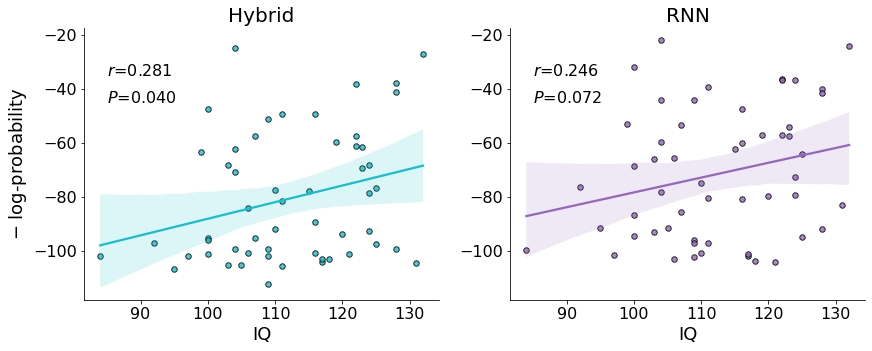

                            OLS Regression Results                            
Dep. Variable:                     oe   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.1026
Date:                Sat, 10 Jun 2023   Prob (F-statistic):              0.750
Time:                        12:17:32   Log-Likelihood:                -76.569
No. Observations:                  54   AIC:                             157.1
Df Residuals:                      52   BIC:                             161.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.76e-16      0.139   1.27e-15      1.0

In [5]:
# plot fig 4_a

fig, axes = plt.subplots(1,2,figsize=(14, 5))

ll_model = [-hybrid7,-rnn]
models = ['Hybrid','RNN']
pla = [sns.color_palette("tab10")[9],sns.color_palette("tab10" )[4]]

for i,m in enumerate(models):
    
    r,p = pearsonr(x=iq,y=ll_model[i])
    sns.regplot(x=iq,
                y=ll_model[i],
                scatter=True,
                color=pla[i],
                scatter_kws={'marker':"o", 's':30,'edgecolors':'k' },
                ax=axes[i]
               )
    
    axes[i].tick_params(axis='x', which='major', labelsize=16)
    axes[i].tick_params(axis='y', which='major', labelsize=16)
    axes[i].set_title(models[i],size=20)
#     axes[i].grid(alpha=.3)
    axes[i].spines.right.set_visible(False)
    axes[i].spines.top.set_visible(False)
    axes[i].text(x=85,y=-35, s='${r}$=%.3f'%r,size=16)     # {\u03C1}
    axes[i].text(x=85,y=-45, s='$\it{P}$=%.3f'%p,size=16)
    


    axes[i].set_xlabel('IQ',size=18)
#     axes[i].set_yticks(ticks=[-120,-90,-60,-30])
#     axes[i].set_xticks(ticks=[90,110,130])
    
axes[0].sharey(axes[1])
axes[0].set_ylabel('${-}$ log-probability',size=18)
axes[1].set_ylabel('',size=18)

# plt.savefig('../plots/fig_4',dpi=300,bbox_inches='tight')
plt.show()

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(np.array(iq).reshape(54,1))
IQ_scale = scaler.transform(np.array(iq).reshape(54,1)).reshape(54,)

scaler = StandardScaler()
scaler.fit(np.array(oe).reshape(54,1))
oe_scale = scaler.transform(np.array(oe).reshape(54,1)).reshape(54,)

df = pd.DataFrame({'IQ':IQ_scale,'oe':oe_scale})


mod = smf.ols(formula='oe ~ IQ', data=df).fit()
print(mod.summary())


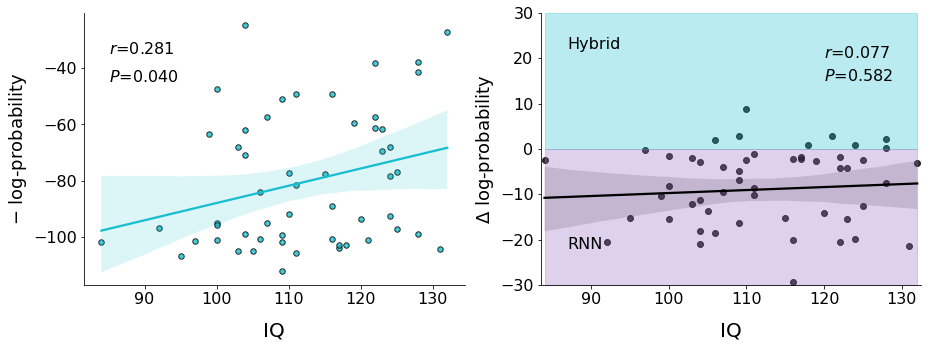

In [6]:
# plot fig 4_a

fig, axes = plt.subplots(1,2,figsize=(15, 5))

ll_model = [-hybrid7 ]# ,-rnn]
models = ['Hybrid']# ,'RNN']
pla = [sns.color_palette("tab10")[9],sns.color_palette("tab10" )[4]]

for i,m in enumerate(models):
    
    r,p = pearsonr(x=iq,y=ll_model[i])
    
    sns.regplot(x=iq,
                y=ll_model[i],
                scatter=True,
                color=pla[i],
                scatter_kws={'marker':"o", 's':30,'edgecolors':'k' },
                ax=axes[0],
               )
    
    axes[0].tick_params(axis='x', which='major', labelsize=16)
    axes[0].tick_params(axis='y', which='major', labelsize=16)

    axes[0].spines.right.set_visible(False)
    axes[0].spines.top.set_visible(False)
    axes[0].set_xlabel('IQ',size=18)
    
    axes[0].text(x=85,y=-35, s='${r}$=%.3f'%r,size=16)     # {\u03C1}
    axes[0].text(x=85,y=-45, s='$\it{P}$=%.3f'%p,size=16)
    

ll_model = [-hybrid7 ,-rnn]
models = ['Hybrid' ,'RNN']    

# from matplotlib.patches import Patch
# from matplotlib.lines import Line2D
# legend_elements = [
#                 Line2D([0],[0] ,lw=3,  color=pla[0], label='Hybrid'),
#               Line2D([0],[0] ,lw=3,  color=pla[1], label='RNN'),
# ]
# axes[0].legend(handles=legend_elements,loc='upper left',fontsize=16)

axes[0].set_ylabel('${-}$ log-probability',size=18)

# slop_hyb, inter_hyb = np.polyfit(x=iq,y=ll_model[0],deg=1)
# slop_rnn, inter_rnn = np.polyfit(x=iq,y=ll_model[1],deg=1)
# sns.lineplot(ax=axes[1],x=x,y=((inter_hyb + slop_hyb*x) - (inter_rnn + slop_rnn*x)),color='k',ls='--')

sns.regplot(ax=axes[1],x=iq,y=ll_model[0]-ll_model[1],color='k')
r,p = pearsonr(x=iq,y=ll_model[0]-ll_model[1])
axes[1].text(x=120,y=20, s='${r}$=%.3f'%r,size=16)     # {\u03C1}
axes[1].text(x=120,y=15, s='$\it{P}$=%.3f'%p,size=16)
axes[1].set_ylim(-30,30)
axes[1].set_xlim(83.5,132.5)
axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)
axes[1].tick_params(axis='x', which='major', labelsize=16)
axes[1].tick_params(axis='y', which='major', labelsize=16)
axes[1].set_ylabel('$\it{Δ}$ log-probability',size=18)

axes[0].set_xlabel('IQ',size=20,labelpad=15)
axes[1].set_xlabel('IQ',size=20,labelpad=15)

x = np.linspace(84,132)
axes[1].fill_between(x=x,y1=0,y2=30,color=pla[0],alpha=.3)
axes[1].fill_between(x=x,y1=0,y2=-30,color=pla[1],alpha=.3)
axes[1].text(x=87,y=22, s='Hybrid',size=16)     
axes[1].text(x=87,y=-22, s='RNN',size=16)

plt.savefig('../plots/fig_6_a_b.pdf',bbox_inches='tight')
plt.show()


In [7]:
# load data and preprocessing 
df = pd.read_csv('../results/hybrid7_lr1_emp.csv')
lr1 = df.groupby('agent').mean()['test_nll_lr']
hybrid7 = df.groupby('agent').mean()['test_nll_hybrid']

df2 = pd.read_csv('../results/hybrid_lr_emp.csv')

lrk = df2.groupby('agent').mean()['test_nll_lr']
hybrid6 = df2.groupby('agent').mean()['test_nll_hybrid']

with open('../results/iq.pickle', 'rb') as handle:
    iq = pickle.load(handle) 

with open('../results/ll_train.pickle', 'rb') as handle:
    ll_train = pickle.load(handle)
    
with open('../results/ll_val.pickle', 'rb') as handle:
    ll_val = pickle.load(handle)
    
with open('../results/ll_test.pickle', 'rb') as handle:
    ll_test = pickle.load(handle)

with open('../results/loss_train.pickle', 'rb') as handle:
    loss_train = pickle.load(handle)
    
with open('../results/loss_val.pickle', 'rb') as handle:
    loss_val = pickle.load(handle)
    
with open('../results/loss_test.pickle', 'rb') as handle:
    loss_test = pickle.load(handle)
    
ll_train = np.array(ll_train).reshape(54,3,1000)
ll_val = np.array(ll_val).reshape(54,3,1000)
ll_test = np.array(ll_test).reshape(54,3,1000)


# for RNN 
best_train = []
best_val = []
best_test = []
optimal_epoch = []

for b in range(3):
    best_train.append(ll_train[:,b,:].min(axis=1))
    best_val.append(ll_val[:,b,:].min(axis=1))
    indx = np.argmin(ll_val[:,b,:],axis=1)
    best_test.append([ll_test[n,b,indx[n]] for n in range(54)])
    optimal_epoch.append(indx)
    
df['train_nll_rnn'] = np.concatenate(best_train)
df['val_nll_rnn'] = np.concatenate(best_val)
df['test_nll_rnn'] = np.concatenate(best_test)
df['optimal_epoch'] = np.concatenate(optimal_epoch)

rnn = df.groupby('agent').mean()['test_nll_rnn']
oe = df.groupby('agent').mean()['optimal_epoch']

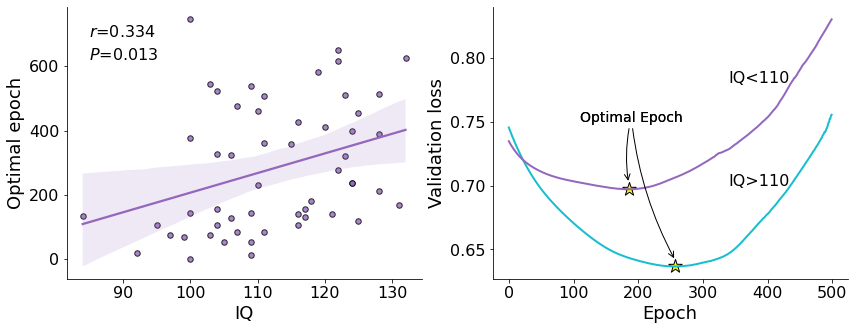

high M=332.80952380952385
high SD=178.0618200451448
low M=227.34615384615387
low SD=206.90228462879617
Ttest_indResult(statistic=2.0119299077244315, pvalue=0.024710820270565797)


In [8]:
# plot fig 6_a

fig, axes = plt.subplots(1,2,figsize=(14, 5))

r, p = pearsonr(x=oe,y=iq)

sns.regplot(x=iq,
            y=oe,
            scatter=True,
            color=pla[1],
            scatter_kws={'marker':"o", 's':30,'edgecolors':'k' },
            ax=axes[0]
           )

axes[0].set_xlabel('IQ',size=18)
axes[0].set_ylabel('Optimal epoch',size=18)
axes[0].tick_params(axis='x', which='major', labelsize=16)
axes[0].tick_params(axis='y', which='major', labelsize=16)
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)
axes[0].text(x=85,y=690, s='${r}$=%.3f'%r,size=16)     # {\u03C1}
axes[0].text(x=85,y=620, s='$\it{P}$=%.3f'%p,size=16)


x = np.array(loss_val).reshape(54,3,1000).mean(axis=1)
a = 110 < np.array(iq)
axes[1].plot(x[a].mean(axis=0)[:500],label='IQ > 110',linewidth=2,color=sns.color_palette("tab10", 10)[9])
axes[1].scatter(x=np.argmin(x[a].mean(axis=0)),y=x[a].mean(axis=0).min(),marker='*',color='yellow',s=200,edgecolors='black')
axes[1].plot(x[~a].mean(axis=0)[:500],label='IQ < 110',linewidth=2,color=sns.color_palette("tab10", 10)[4])
axes[1].scatter(x=np.argmin(x[~a].mean(axis=0)),y=x[~a].mean(axis=0).min(),marker='*',color='yellow',s=200,edgecolors='black')
# axes[1].legend(fontsize=16)
axes[1].set_xlabel('Epoch',size=18)
axes[1].set_ylabel('Validation loss',size=18)

axes[1].tick_params(axis='x', which='major', labelsize=16)
axes[1].tick_params(axis='y', which='major', labelsize=16)
axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)


axes[1].annotate("Optimal Epoch",
            xy=(np.argmin(x[a].mean(axis=0)),x[a].mean(axis=0).min()+.005),
            xycoords='data',size=14,
            xytext=(110, .75), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",connectionstyle="arc3,rad=0.1"),
            )

axes[1].annotate("Optimal Epoch",
            xy=(np.argmin(x[~a].mean(axis=0)),x[~a].mean(axis=0).min()+.005),
            xycoords='data',size=14,
            xytext=(110, .75), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="k",connectionstyle="arc3,rad=0.1"),
            )


axes[1].text(x=340,y=.78, s='IQ<110',size=16)
axes[1].text(x=340,y=.700, s='IQ>110',size=16)


plt.savefig('../plots/fig_7.pdf',bbox_inches='tight')
plt.show()

print(f'high M={oe[a].mean()}')
print(f'high SD={oe[a].std()}')

print(f'low M={oe[~a].mean()}')
print(f'low SD={oe[~a].std()}')
print(stats.ttest_ind(a=oe[a],b=oe[~a],alternative='greater'))
